# Execution Engine Demo: Computing Mechanical Parameters via All Possible Pathways

This notebook demonstrates the new **Execution Engine** feature that automatically computes mechanical parameters using all possible calculation pathways defined in the parameterization graph.

## Key Concepts

- **Parameterization Graph**: A directed acyclic graph (DAG) that defines all possible ways to calculate mechanical parameters from measured inputs
- **Pathway**: A specific sequence of methods from measured inputs to a target parameter
- **ExecutionEngine**: Executes all pathways and returns results for each

## What This Notebook Covers

1. Creating Layer and Slab objects from measured data
2. Listing all available calculation pathways
3. Executing all pathways for a target parameter
4. Comparing results across different pathways
5. Using real SnowPilot data with the execution engine

In [1]:
# Import standard libraries
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add paths for local imports
sys.path.insert(0, '../src')
sys.path.insert(0, '../algorithm')

# Import from uncertainties for creating measured values with uncertainty
from uncertainties import ufloat

# Import snowpyt_mechparams components
from snowpyt_mechparams import Layer, Slab
from snowpyt_mechparams.execution import ExecutionEngine, ExecutionResults, PathwayResult

# Import the parameterization graph
from definitions import graph

# Import SnowPilot utilities for parsing real data
from snowpilot_utils import parse_sample_pits, pit_to_slab_above_weak_layer, pit_to_layers

print("Imports successful!")

Imports successful!


/Users/marykate/Desktop/Snow/SnowPyt-MechParams/venv/lib/python3.14/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


## 1. Creating Test Data

First, let's create a simple slab with measured data. We'll include:
- Hand hardness (for density estimation)
- Grain form (used by multiple methods)
- Optional: Direct density measurements

In [2]:
# Create a 3-layer slab with mixed measurement availability
layers = [
    # Layer 0: Surface layer with direct density measurement
    Layer(
        depth_top=0,
        thickness=15,
        hand_hardness='1F',
        grain_form='RG',  # Rounded grains
        grain_size_avg=ufloat(1.0, 0.1),
        density_measured=ufloat(280, 25)  # kg/m³
    ),
    # Layer 1: Middle layer - no direct density, will be estimated
    Layer(
        depth_top=15,
        thickness=20,
        hand_hardness='P',
        grain_form='FC',  # Faceted crystals
        grain_size_avg=ufloat(2.0, 0.2)
    ),
    # Layer 2: Bottom layer with direct density
    Layer(
        depth_top=35,
        thickness=25,
        hand_hardness='4F',
        grain_form='DF',  # Decomposing/fragmented
        grain_size_avg=ufloat(0.5, 0.05),
        density_measured=ufloat(200, 18)
    )
]

# Create the slab with a 35° slope angle
test_slab = Slab(layers=layers, angle=35.0)

print(f"Created slab with {len(test_slab.layers)} layers")
print(f"Total thickness: {test_slab.total_thickness} cm")
print(f"Slope angle: {test_slab.angle}°")
print()

# Display layer details
for i, layer in enumerate(test_slab.layers):
    print(f"Layer {i}:")
    print(f"  Depth: {layer.depth_top} - {layer.depth_bottom} cm")
    print(f"  Hand hardness: {layer.hand_hardness}")
    print(f"  Grain form: {layer.grain_form}")
    print(f"  Density measured: {layer.density_measured}")
    print()

Created slab with 3 layers
Total thickness: 60 cm
Slope angle: 35.0°

Layer 0:
  Depth: 0 - 15 cm
  Hand hardness: 1F
  Grain form: RG
  Density measured: 280+/-25

Layer 1:
  Depth: 15 - 35 cm
  Hand hardness: P
  Grain form: FC
  Density measured: None

Layer 2:
  Depth: 35 - 60 cm
  Hand hardness: 4F
  Grain form: DF
  Density measured: 200+/-18



## 2. Initialize the Execution Engine

The `ExecutionEngine` takes the parameterization graph and provides methods to:
- List all available pathways for a target parameter
- Execute all pathways on a slab
- Execute a specific pathway by method names

In [3]:
# Initialize the execution engine with the graph
engine = ExecutionEngine(graph)

print("Execution engine initialized.")
print("\nAvailable target parameters:")
print("  - density")
print("  - elastic_modulus")
print("  - poissons_ratio")
print("  - shear_modulus")

Execution engine initialized.

Available target parameters:
  - density
  - elastic_modulus
  - poissons_ratio
  - shear_modulus


## 3. List Available Pathways

Before executing, let's see all the possible pathways for computing elastic modulus.

In [4]:
# List all available pathways for elastic_modulus
pathways = engine.list_available_pathways('elastic_modulus')

print(f"Found {len(pathways)} possible pathways for computing elastic_modulus:\n")

for i, pathway in enumerate(pathways, 1):
    print(f"{i:2d}. {pathway['description']}")
    print(f"    Methods: {pathway['methods']}")
    print()

Found 16 possible pathways for computing elastic_modulus:

 1. density=data_flow | elastic_modulus=bergfeld
    Methods: {'density': 'data_flow', 'elastic_modulus': 'bergfeld'}

 2. density=geldsetzer | elastic_modulus=bergfeld
    Methods: {'density': 'geldsetzer', 'elastic_modulus': 'bergfeld'}

 3. density=kim_jamieson_table2 | elastic_modulus=bergfeld
    Methods: {'density': 'kim_jamieson_table2', 'elastic_modulus': 'bergfeld'}

 4. density=kim_jamieson_table5 | elastic_modulus=bergfeld
    Methods: {'density': 'kim_jamieson_table5', 'elastic_modulus': 'bergfeld'}

 5. density=data_flow | elastic_modulus=kochle
    Methods: {'density': 'data_flow', 'elastic_modulus': 'kochle'}

 6. density=geldsetzer | elastic_modulus=kochle
    Methods: {'density': 'geldsetzer', 'elastic_modulus': 'kochle'}

 7. density=kim_jamieson_table2 | elastic_modulus=kochle
    Methods: {'density': 'kim_jamieson_table2', 'elastic_modulus': 'kochle'}

 8. density=kim_jamieson_table5 | elastic_modulus=kochle

## 4. Execute All Pathways

Now let's execute all pathways and see the results. The engine will:
1. Find all parameterizations for the target parameter
2. Execute each one on a deep copy of the slab
3. Return results keyed by pathway description

In [5]:
# Execute all pathways for elastic_modulus
results = engine.execute_all(
    slab=test_slab,
    target_parameter='elastic_modulus',
    include_plate_theory=True  # Also compute A11, B11, D11, A55
)

print("=== Execution Summary ===")
print(f"Target parameter: {results.target_parameter}")
print(f"Total pathways attempted: {results.total_pathways}")
print(f"Successful pathways: {results.successful_pathways}")
print(f"Failed pathways: {results.failed_pathways}")

=== Execution Summary ===
Target parameter: elastic_modulus
Total pathways attempted: 16
Successful pathways: 16
Failed pathways: 0


## 5. Explore Results by Pathway

Each pathway result contains:
- `methods_used`: Dictionary of parameter → method name
- `layer_results`: List of LayerResult objects with computed values
- `slab_result`: SlabResult with plate theory parameters (A11, B11, D11, A55)
- `success`: Whether the pathway produced results

In [6]:
# Explore the first 3 successful pathways in detail
count = 0
for pathway_desc, result in results.results.items():
    if result.success and count < 3:
        print(f"\n{'='*60}")
        print(f"Pathway: {pathway_desc}")
        print(f"{'='*60}")
        print(f"\nMethods used: {result.methods_used}")
        print(f"\nLayer Results:")
        
        for lr in result.layer_results:
            layer = lr.layer
            print(f"\n  Layer {lr.layer_index} (depth {layer.depth_top}-{layer.depth_bottom} cm):")
            print(f"    Grain form: {layer.grain_form}")
            
            if layer.density_calculated is not None:
                print(f"    Density (calculated): {layer.density_calculated:.1f} kg/m³")
            elif layer.density_measured is not None:
                print(f"    Density (measured): {layer.density_measured:.1f} kg/m³")
            
            if layer.elastic_modulus is not None:
                print(f"    Elastic modulus: {layer.elastic_modulus:.2f} MPa")
            else:
                print(f"    Elastic modulus: Not computed (method may not support grain form)")
        
        # Show method call trace for first layer
        print(f"\n  Method calls for Layer 0:")
        for mc in result.layer_results[0].method_calls:
            status = "✓" if mc.success else "✗"
            print(f"    {status} {mc.parameter}.{mc.method_name}")
            if not mc.success and mc.failure_reason:
                print(f"      Reason: {mc.failure_reason}")
        
        count += 1


Pathway: density=data_flow | elastic_modulus=bergfeld

Methods used: {'density': 'data_flow', 'elastic_modulus': 'bergfeld'}

Layer Results:

  Layer 0 (depth 0-15 cm):
    Grain form: RG
    Density (calculated): 280.0+/-25.0 kg/m³
    Elastic modulus: 35.15+/-15.72 MPa

  Layer 1 (depth 15-35 cm):
    Grain form: FC
    Elastic modulus: Not computed (method may not support grain form)

  Layer 2 (depth 35-60 cm):
    Grain form: DF
    Density (calculated): 200.0+/-18.0 kg/m³
    Elastic modulus: 8.00+/-3.85 MPa

  Method calls for Layer 0:
    ✓ density.data_flow
    ✓ elastic_modulus.bergfeld

Pathway: density=geldsetzer | elastic_modulus=bergfeld

Methods used: {'density': 'geldsetzer', 'elastic_modulus': 'bergfeld'}

Layer Results:

  Layer 0 (depth 0-15 cm):
    Grain form: RG
    Density (calculated): 202.1+/-46.0 kg/m³
    Elastic modulus: 8.37+/-8.69 MPa

  Layer 1 (depth 15-35 cm):
    Grain form: FC
    Density (calculated): 296.0+/-43.0 kg/m³
    Elastic modulus: Not comp

## 6. Compare Results Across Pathways

Let's create a comparison table showing how elastic modulus values vary by pathway and layer.

In [7]:
# Build comparison data
comparison_data = []

for pathway_desc, result in results.results.items():
    if result.success:
        for lr in result.layer_results:
            layer = lr.layer
            if layer.elastic_modulus is not None:
                # Get method names
                density_method = result.methods_used.get('density', 'N/A')
                emod_method = result.methods_used.get('elastic_modulus', 'N/A')
                
                comparison_data.append({
                    'Layer': lr.layer_index,
                    'Grain Form': layer.grain_form,
                    'Density Method': density_method,
                    'E Method': emod_method,
                    'E (MPa)': layer.elastic_modulus.nominal_value,
                    'E Uncertainty (MPa)': layer.elastic_modulus.std_dev
                })

# Create DataFrame
if comparison_data:
    df = pd.DataFrame(comparison_data)
    
    # Display pivot table grouped by layer
    print("Elastic Modulus Comparison by Layer and Method Combination:\n")
    pivot = df.pivot_table(
        values='E (MPa)',
        index=['Layer', 'Grain Form'],
        columns=['Density Method', 'E Method'],
        aggfunc='mean'
    )
    print(pivot.round(2).to_string())
else:
    print("No successful elastic modulus calculations to compare.")

Elastic Modulus Comparison by Layer and Method Combination:

Density Method   data_flow                           geldsetzer                          kim_jamieson_table2                          kim_jamieson_table5                          
E Method          bergfeld  kochle schottner wautier   bergfeld kochle schottner wautier            bergfeld kochle schottner wautier            bergfeld  kochle schottner wautier
Layer Grain Form                                                                                                                                                                   
0     RG             35.15  131.54     17.06   51.50       8.37  18.22      3.81   24.01                9.18  21.59      4.19   25.22               35.15  131.54     17.06   51.50
1     FC               NaN     NaN       NaN     NaN        NaN    NaN     56.33   58.65                 NaN    NaN     66.07   63.10                 NaN     NaN     97.78   75.54
2     DF              8.00     NaN     

## 7. Execute a Specific Pathway

If you want to run only a specific combination of methods, use `execute_single()`.

In [8]:
# Execute a specific pathway: data_flow for density, wautier for elastic modulus
specific_result = engine.execute_single(
    slab=test_slab,
    target_parameter='elastic_modulus',
    methods={
        'density': 'data_flow',  # Use measured density directly
        'elastic_modulus': 'wautier'
    },
    include_plate_theory=True
)

if specific_result:
    print(f"Executed pathway: {specific_result.pathway_description}")
    print(f"Success: {specific_result.success}")
    print("\nLayer results:")
    
    for lr in specific_result.layer_results:
        layer = lr.layer
        print(f"\n  Layer {lr.layer_index}:")
        print(f"    Density: {layer.density_calculated}")
        print(f"    Elastic modulus: {layer.elastic_modulus}")
else:
    print("Pathway not found or failed.")

Executed pathway: density=data_flow | elastic_modulus=wautier
Success: True

Layer results:

  Layer 0:
    Density: 280+/-25
    Elastic modulus: 51+/-14

  Layer 1:
    Density: None
    Elastic modulus: None

  Layer 2:
    Density: 200+/-18
    Elastic modulus: 23+/-6


/Users/marykate/Desktop/Snow/SnowPyt-MechParams/venv/lib/python3.14/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


## 8. Computing Shear Modulus with Plate Theory

Let's compute shear modulus which includes the A55 plate theory parameter.

In [9]:
# Execute for shear modulus (simpler - only one method)
shear_results = engine.execute_all(
    slab=test_slab,
    target_parameter='shear_modulus',
    include_plate_theory=True
)

print(f"Shear modulus pathways: {shear_results.total_pathways}")
print(f"Successful: {shear_results.successful_pathways}")

# Show first successful result with plate theory
for pathway_desc, result in shear_results.results.items():
    if result.success:
        print(f"\n=== {pathway_desc} ===")
        print(f"\nLayer shear modulus values:")
        
        for lr in result.layer_results:
            layer = lr.layer
            if layer.shear_modulus is not None:
                print(f"  Layer {lr.layer_index}: G = {layer.shear_modulus:.2f} MPa")
        
        if result.slab_result and result.slab_result.A55 is not None:
            print(f"\nSlab shear stiffness (κ*A55): {result.slab_result.A55:.2f} N/mm")
        
        break  # Just show first

Shear modulus pathways: 4
Successful: 4

=== density=data_flow | shear_modulus=wautier ===

Layer shear modulus values:
  Layer 0: G = 19.10+/-5.26 MPa
  Layer 2: G = 8.21+/-2.27 MPa


## 9. Working with Real SnowPilot Data

Now let's apply the execution engine to real snow pit data from SnowPilot.

In [10]:
# Parse a few sample pits (this may take a moment)
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Get just 10 pits for demo purposes
all_pits = parse_sample_pits('data')
sample_pits = all_pits[:10] if len(all_pits) >= 10 else all_pits

print(f"\nUsing {len(sample_pits)} sample pits for demo")

Successfully parsed 50278 files
Failed to parse 0 files

Using 10 sample pits for demo


In [11]:
# Process each pit through the execution engine
pit_results = []

for i, pit in enumerate(sample_pits):
    try:
        # Convert pit to slab (all layers)
        slab = pit_to_slab_above_weak_layer(pit, weak_layer_def=None)
        
        if slab is None or len(slab.layers) == 0:
            continue
        
        # Execute all pathways for elastic modulus
        results = engine.execute_all(
            slab=slab,
            target_parameter='elastic_modulus',
            include_plate_theory=False  # Skip plate theory for speed
        )
        
        # Store summary
        pit_results.append({
            'pit_id': pit.core_info.pit_id if hasattr(pit.core_info, 'pit_id') else f'pit_{i}',
            'num_layers': len(slab.layers),
            'total_pathways': results.total_pathways,
            'successful_pathways': results.successful_pathways,
            'success_rate': results.successful_pathways / results.total_pathways if results.total_pathways > 0 else 0
        })
        
    except Exception as e:
        # Skip pits that fail to process
        pass

# Create summary DataFrame
if pit_results:
    pit_summary = pd.DataFrame(pit_results)
    print("SnowPilot Pit Processing Summary:\n")
    print(pit_summary.to_string(index=False))
    
    print(f"\n\nAggregate Statistics:")
    print(f"  Pits processed: {len(pit_results)}")
    print(f"  Average layers per pit: {pit_summary['num_layers'].mean():.1f}")
    print(f"  Average pathway success rate: {pit_summary['success_rate'].mean()*100:.1f}%")
else:
    print("No pits were successfully processed.")

SnowPilot Pit Processing Summary:

pit_id  num_layers  total_pathways  successful_pathways  success_rate
 51686           7              16                    8        0.5000
  5847           4              16                    9        0.5625
  9544          16              16                    2        0.1250
 30734           6              16                    8        0.5000
 43746           4              16                   11        0.6875
 18792           7              16                    0        0.0000
 11399           8              16                    9        0.5625
 51365          10              16                   11        0.6875
 39615           6              16                    6        0.3750
 58244           7              16                   10        0.6250


Aggregate Statistics:
  Pits processed: 10
  Average layers per pit: 7.5
  Average pathway success rate: 46.2%


## 10. Visualizing Method Comparison

Let's create a visualization comparing elastic modulus estimates from different methods.

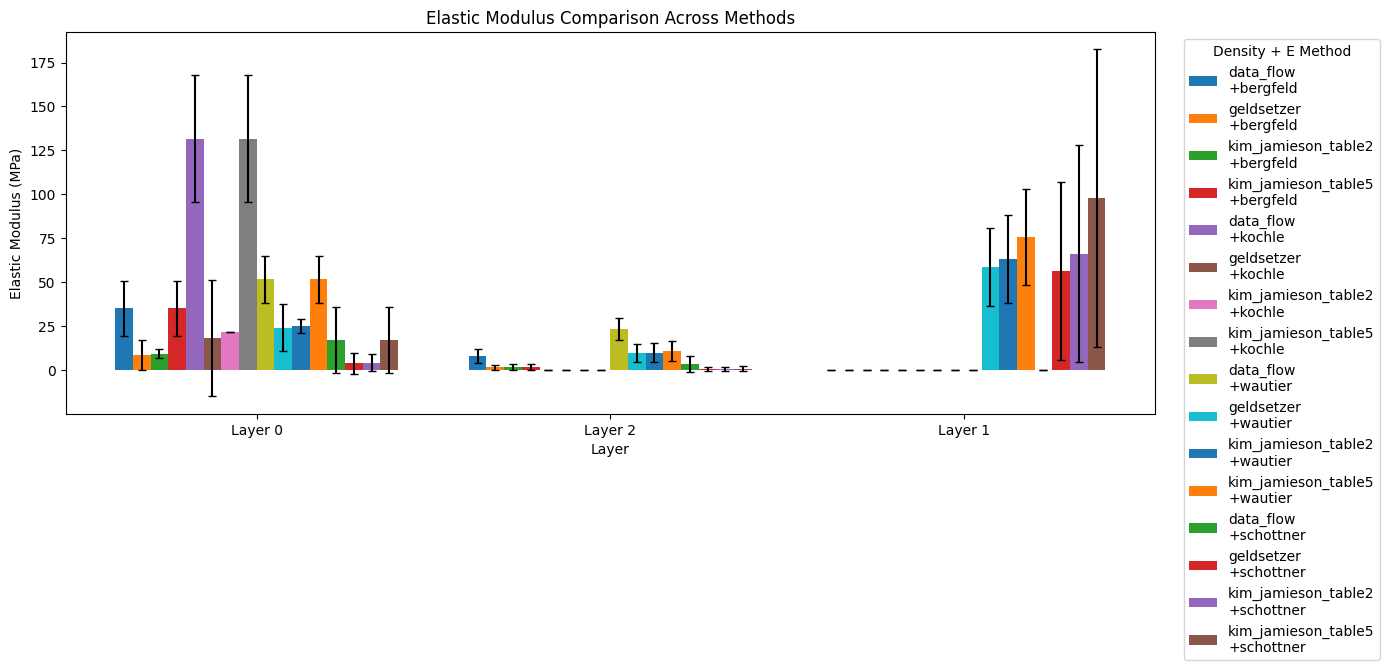

In [12]:
# Use our test slab to compare methods
results = engine.execute_all(
    slab=test_slab,
    target_parameter='elastic_modulus',
    include_plate_theory=False
)

# Collect E values by method for layers with computed values
plot_data = []
for pathway_desc, result in results.results.items():
    if result.success:
        density_method = result.methods_used.get('density', 'N/A')
        emod_method = result.methods_used.get('elastic_modulus', 'N/A')
        
        for lr in result.layer_results:
            if lr.layer.elastic_modulus is not None:
                plot_data.append({
                    'Layer': f"Layer {lr.layer_index}",
                    'Method': f"{density_method}\n+{emod_method}",
                    'E (MPa)': lr.layer.elastic_modulus.nominal_value,
                    'E_err': lr.layer.elastic_modulus.std_dev
                })

if plot_data:
    df_plot = pd.DataFrame(plot_data)
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    layers = df_plot['Layer'].unique()
    methods = df_plot['Method'].unique()
    
    x = np.arange(len(layers))
    width = 0.8 / len(methods)
    
    for i, method in enumerate(methods):
        method_data = df_plot[df_plot['Method'] == method]
        values = []
        errors = []
        for layer in layers:
            layer_method_data = method_data[method_data['Layer'] == layer]
            if not layer_method_data.empty:
                values.append(layer_method_data['E (MPa)'].values[0])
                errors.append(layer_method_data['E_err'].values[0])
            else:
                values.append(0)
                errors.append(0)
        
        ax.bar(x + i*width, values, width, label=method, yerr=errors, capsize=3)
    
    ax.set_xlabel('Layer')
    ax.set_ylabel('Elastic Modulus (MPa)')
    ax.set_title('Elastic Modulus Comparison Across Methods')
    ax.set_xticks(x + width * (len(methods) - 1) / 2)
    ax.set_xticklabels(layers)
    ax.legend(title='Density + E Method', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

## Summary

This notebook demonstrated the key features of the Execution Engine:

1. **`ExecutionEngine(graph)`**: Initialize with the parameterization graph
2. **`list_available_pathways(target)`**: See all possible calculation pathways
3. **`execute_all(slab, target)`**: Run all pathways and get comprehensive results
4. **`execute_single(slab, target, methods)`**: Run a specific pathway

### Result Structure

- **`ExecutionResults`**: Top-level container with pathway_description → PathwayResult
- **`PathwayResult`**: Contains methods_used, layer_results, slab_result, success
- **`LayerResult`**: Contains layer with computed values and method_calls trace
- **`SlabResult`**: Contains plate theory parameters (A11, B11, D11, A55)

### Key Benefits

- **Comprehensive**: Automatically computes all possible method combinations
- **Traceable**: Full record of which methods produced which values
- **Flexible**: Handles missing data gracefully (skips silently)
- **Extensible**: Easy to add new methods to the graph